In [2]:
# Load libriaries.
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import FastICA, PCA

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

In [3]:
# Define helper functions.
scaler = StandardScaler(copy=True) # Define standard scaler instance.
detector = IsolationForest(n_estimators=1000, random_state=0) # Define outlier detector instance.
imputer = KNNImputer() # Define imputation instance.
decomposition = FastICA(n_components=None) # Define independent component analysis instance.
dim_red = PCA(n_components=2, copy=True, whiten=False)

# Define exponential moving average function.
def exponential_moving_average(s, a):
    T = len(s)
    r = np.zeros((T))
    r[0] = s[0]
    for k in range(1, T):
        r[k] = (1-a)*r[k-1]+a*(s[k]-s[k-1])
    return r

In [4]:
# Load data and keep only first six months.
data = pd.read_excel("data.xlsx")
data = data[data["Date"] <= "2004-09-10"]

# Visualize data summary.
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,3447.000000,4275.000000,914.000000,4275.000000,4275.000000,3525.000000,4275.000000,3522.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000
mean,1.918422,1077.334113,218.811816,9.850661,937.848090,126.051348,897.271150,94.706133,1617.936394,944.460370,23.451201,42.485045,1.153040
std,1.206673,200.344215,204.459921,6.566329,240.489984,83.970746,228.686816,36.637686,255.788785,343.175279,7.843419,15.985736,0.343338
min,0.100000,708.000000,7.000000,0.464418,437.000000,2.000000,387.500000,5.000000,955.000000,263.000000,6.100000,9.175000,0.375444
25%,1.000000,932.250000,67.000000,4.843458,755.500000,63.000000,735.875000,67.000000,1441.750000,692.875000,17.300000,29.500000,0.904255
50%,1.700000,1047.500000,150.000000,8.499723,919.500000,108.000000,860.000000,94.000000,1587.000000,896.500000,23.450000,42.500000,1.096318
75%,2.500000,1184.250000,297.000000,13.385657,1096.500000,168.000000,1022.750000,119.000000,1752.625000,1150.625000,28.600000,54.000000,1.366492
max,8.100000,2039.750000,1189.000000,40.260061,1776.250000,631.000000,1940.750000,233.000000,2746.000000,2474.750000,44.600000,85.150002,2.180639


In [23]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns]

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)

# Restore frame.
data = pd.DataFrame(X_t, columns=columns)
t = np.linspace(0, data.shape[0], data.shape[0])/24
data["time"] = t

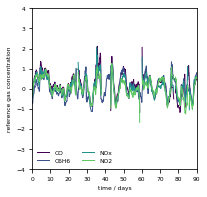

In [11]:
# Define outputs.
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

# Plot different references.
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(outputs):
    plt.plot(data.rolling(24, min_periods=1, center=True).mean()["time"], 
             data.rolling(24, min_periods=1, center=True).mean()[label], 
             color=plt.cm.viridis(k/len(outputs)), label=label[:-4])
plt.xlabel("time / days")
plt.ylabel("reference gas concentration")
plt.legend(loc=3, frameon=False, ncol=2)
plt.xlim((0, 90))
plt.ylim((-4.0, 4.0))
plt.savefig("./figures/time_series_references",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')

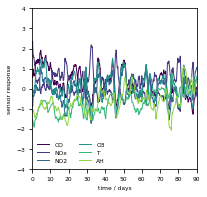

In [15]:
# Define outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
labels = [item.split("(")[-1].split(")")[0] for item in inputs] # Customize labels.

# Plot different references.
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(inputs):
    plt.plot(data.rolling                                   (24, min_periods=1, center=True).mean()["time"], 
             data.rolling(24, min_periods=1, center=True).mean()[label], 
             color=plt.cm.viridis(k/len(inputs)), label=labels[k])
plt.xlabel("time / days")
plt.ylabel("sensor response")
plt.legend(loc=3, frameon=False, ncol=2)
plt.xlim((0, 90))
plt.ylim((-4.0, 4.0))
plt.savefig("./figures/time_series_sensors",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')

In [8]:
# Perform dimensionality reduction.
columns = ["T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data_ = data[columns]
data_.index = pd.to_datetime(data["Date"])
data_ = data_.dropna()
data_["Interval"] = 0

# Define time span.
delta = pd.Timedelta("10 days")

# Slice data.
for k in range(20):
    data_.loc[(data_.index > (data_.index[0] + (k)*delta)), "Interval"] = k
    
X = scaler.fit_transform(data_[data_["Interval"] < 20].drop(columns=["Interval"]).values)

Y = dim_red.fit_transform(X)

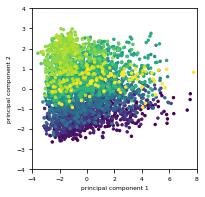

In [9]:
fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.scatter(Y[:, 0], Y[:, 1], c=data_[data_["Interval"] < 20]["Interval"], cmap=plt.cm.viridis, s=6, alpha=1.0)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_xlim((-4,8))
ax.set_ylim((-4,4))
plt.savefig('./figures/time_series_PCA',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

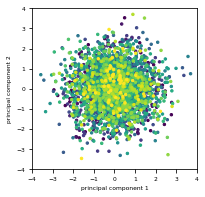

In [7]:
X_random = np.random.normal(size=X.shape)
Y_random = dim_red.fit_transform(X_random)

fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.scatter(Y_random[:, 0], Y_random[:, 1], c=data_[data_["Interval"] < 20]["Interval"], cmap=plt.cm.viridis, s=6, alpha=1.0)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
plt.savefig('./figures/time_series_PCA_random',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()